**A- Data Gathering**

In [1]:
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import json
import warnings
from scipy import stats
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#1- read twitter_archive_enhanced
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#2- Downloading image-predictions.tsv from url 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)

if not os.path.isfile(file_name):
    with open(file_name, mode = 'wb') as f:
        f.write(response.content)
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [4]:
#3- Gathering Data from twitter ApI
consumer_key = '**************************'
consumer_secret = '**********************************'
access_token = '*********************************'
access_secret = '**************************************'

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
#explore the keys of the data
exp_tweet = api.get_status(archive_df.tweet_id[1991], tweet_mode = 'extended')
content = exp_tweet._json
content.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [7]:
#creat tweet_json.txt from twitter API
deleted_tweets_ids = [] 
if not os.path.isfile('tweet_json.txt'):
    with open ('tweet_json.txt', 'w') as file:
        for tweet in archive_df['tweet_id'] :
            try:
                status = api.get_status(tweet, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet) + ";" + str(e))
                deleted_tweets_ids.append(tweet)

In [8]:
deleted_tweets_ids

[]

In [9]:
#List of dictionaries and later convert to a DataFrame
api_list = []
with open("tweet_json.txt", 'r') as file:
    for line in file:
        dic = json.loads(line)
        api_list.append(dic)
        
api_df = pd.DataFrame(api_list, columns = ['id_str', 'retweet_count', 'favorite_count'])

end of gathering

now we have three dataframes archive_df , image_df and api_df

with three outputs image-predictions.tsv , tweet_json.txt and twitter-archive-enhanced.csv

**B- Assessing**

**1- Quality**

*a- archive_df*

1-tweet_id is int - better to be a string

2- timestamp is string

3-all empty cells (NaN) represnted by None as a string

4- df has retweets and replies - as required should be deleted

5- expanded url has NaN values, which means missing image

6- df has deleted tweets

7-nominator and dominator values

    7-a- vales are (int) but by visualization by excel, I've found that many ratings is (float)
    
    7-b - some ratings not correct extracted from the text
        
    7-c- many values greater than 10, by visualization by excel, I've found that the images related to those ratings has many dogs
        
     7-d- rating 24/7 was recorded but after the tweet, that is not a rating (tweet id =810984652412424192)
        
     7-e- rating_numerator has outlier = 1776
        
     7-f- rating_numerator has value = 420 , but the iomage isn't for a dog (tweet id = 855862651834028034)
        
8- some names wrong extracted - a, an , the , actually, etc

9- source is a useless column

10- archive_df has deleted ids


**b- api_df**

11- api_df extracted from archive_df, so it contains also retweets and replies

**c- image_prediction_df**

12-tweet_id is int - better to be a string

***2-Tidiness***

1- expanded url - column's name isn't clear enough 

2- dog stage (doggo, floofer, pupper and puppo) represented in 4 columns instead of one

3- image_prediction headers aren't clear enough

4- dog prediction separated  to 3 columns and also dog breed and dog confidence

5-the indication of true and false values in image_df isn't clear enough

In [10]:
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
archive_df.shape

(2356, 17)

In [13]:
sum(archive_df.duplicated())

0

In [14]:
for c in archive_df['name']:
    if c.islower():
         print (c)

such
a
quite
quite
quite
not
one
incredibly
a
mad
an
very
a
very
just
my
one
not
his
one
a
a
a
an
very
actually
a
just
getting
mad
very
this
unacceptable
all
a
old
a
infuriating
a
a
a
an
a
a
very
getting
just
a
the
the
actually
by
a
officially
a
the
the
a
a
a
a
life
a
one
a
a
a
light
just
space
a
the
a
a
a
a
a
a
a
a
a
an
a
the
a
a
a
a
a
a
a
a
a
a
a
quite
a
an
a
an
the
the
a
a
an
a
a
a
a


In [15]:
archive_df.name.value_counts(dropna=False)

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
the            8
Sadie          8
Daisy          7
Buddy          7
Bailey         7
an             7
Toby           7
Jack           6
Rusty          6
Koda           6
Leo            6
Scout          6
Oscar          6
Jax            6
Milo           6
Bella          6
Stanley        6
Dave           6
Gus            5
            ... 
Tilly          1
Cermet         1
Stewie         1
Miguel         1
Charleson      1
DayZ           1
Jiminus        1
Grizzie        1
Harnold        1
Kulet          1
Milky          1
Georgie        1
Luther         1
Jeb            1
Ginger         1
Maisey         1
Jeffri         1
Crawford       1
Bobby          1
Deacon         1
Striker        1
Shelby         1
Philippe       1
Keet           1
Rose           1
Chadrick       1
Clarq          1
Brandi        

In [16]:
archive_df.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [17]:
archive_df.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [18]:
sum(archive_df.expanded_urls.isnull())

59

In [19]:
archive_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [20]:
image_predictions_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [21]:
image_predictions_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [22]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
sum(image_predictions_df.jpg_url.isnull())

0

In [24]:
image_predictions_df.shape

(2075, 12)

In [25]:
api_df.shape

(2331, 3)

In [26]:
api_df.head(5)

,id_str,retweet_count,favorite_count
0,892420643555336193,7549,35695
1,892177421306343426,5595,30872
2,891815181378084864,3705,23207
3,891689557279858688,7731,38992
4,891327558926688256,8332,37253


In [27]:
api_df.describe()

,retweet_count,favorite_count
count,2331.00000,2331.000000
mean,2653.46332,7459.375375
std,4487.88697,11581.311398
min,1.00000,0.000000
25%,537.00000,1297.500000
50%,1242.00000,3243.000000
75%,3081.00000,9137.000000
max,76265.00000,153909.000000


In [28]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id_str            2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


**clean**

In [29]:
#make a copy of all the dataframes
archive_df_clean = archive_df.copy()
image_df_clean = image_predictions_df.copy()
api_df_clean = api_df.copy()

*Define*

archive_df/1 Tweet id is int
convert it to string, as it will not be involved in any mathematical equations or functions

Code

In [30]:
archive_df_clean.tweet_id = archive_df_clean.tweet_id.astype('str')

Test

In [31]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

define

2- timestamp is object

convert timestamp from string to datetime

Code

In [32]:
archive_df_clean["timestamp"]= pd.to_datetime(archive_df_clean["timestamp"])

Test

In [33]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

Define

3- NaN values represented as none (as a string)

convert all none to NaN

In [34]:
archive_df_clean = archive_df_clean.replace(to_replace =["None"], value = np.nan)

Test

In [35]:
archive_df_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
257,843856843873095681,NaN,NaN,2017-03-20 16:08:44,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Sadie and Daisy. They do all thei...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/843856843...,12,10,Sadie,NaN,NaN,NaN,NaN
742,780476555013349377,NaN,NaN,2016-09-26 18:38:05,"<a href=""http://twitter.com/download/iphone"" r...",RT @Patreon: Well. @dog_rates is on Patreon. \...,7.804657e+17,1.228326e+09,2016-09-26 17:55:00 +0000,"https://www.patreon.com/WeRateDogs,https://twi...",12,10,NaN,NaN,NaN,NaN,NaN
138,865718153858494464,NaN,NaN,2017-05-19 23:57:46,"<a href=""http://twitter.com/download/iphone"" r...",Meet Boomer. He's just checking pup on you. Ho...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/865718153...,13,10,Boomer,NaN,NaN,NaN,NaN
1346,704480331685040129,NaN,NaN,2016-03-01 01:36:14,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lucia. She's a Cumulonimbus Floofmallow. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704480331...,11,10,Lucia,NaN,NaN,NaN,NaN
1156,724771698126512129,NaN,NaN,2016-04-26 01:26:53,"<a href=""http://twitter.com/download/iphone"" r...",Nothin better than a doggo and a sunset. 11/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/724771698...,11,10,NaN,doggo,NaN,NaN,NaN


define

4- df has retweets and replies - as required should be deleted

as required retweets and replies should be deleted.

At fist we should delete the rows, that have either retweets or replies. we can catch them by checking in_reply_to_status_id and retweet_status_id 

then we should delete the columns

Code

In [36]:
#removal of retweets rows
retweet_entries = archive_df_clean.retweeted_status_id.notnull()
archive_df_clean[retweet_entries].shape[0]

181

In [37]:
archive_df_clean = archive_df_clean[~retweet_entries]

In [38]:
#removal of replies
in_reply_entries = archive_df_clean.in_reply_to_status_id.notnull()
archive_df_clean[in_reply_entries].shape[0]

78

In [39]:
archive_df_clean = archive_df_clean[~in_reply_entries]

In [40]:
#removal of retweets and replies columns
archive_df_clean = archive_df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp'], axis=1)

Test

In [41]:
archive_df_clean.shape

(2097, 12)

In [42]:
archive_df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

Define

5- expanded url has NaN values, which means missing image & expanded url - column's name isn't clear enough

-Quality issue: remove all rows, that have empty expanded url
    
as required our goal is only original tweets with images

Tidness issue: Rename expanded urls to image_url

Code

In [43]:
expanded_urls_entries = archive_df_clean.expanded_urls.notnull()
archive_df_clean[expanded_urls_entries].shape[0]

2094

In [44]:
archive_df_clean = archive_df_clean[expanded_urls_entries]

In [45]:
archive_df_clean = archive_df_clean.rename(columns={"expanded_urls": "image_urls"})

Test

In [46]:
archive_df_clean.shape

(2094, 12)

In [47]:
archive_df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'image_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

Define

6-remove deleted tweets - we've already detect them from api_df

- archive_df doesn't have a column for deleted ids and api_df doesn't contain them also

later we need to join both of them(archive_df & api_df)

Code

In [48]:
archive_df_clean = archive_df_clean[archive_df_clean['tweet_id'].isin(api_df_clean['id_str'])]

Test

In [49]:
archive_df_clean.shape

(2087, 12)

Define

7- nominator and dominator values

7-a- vales are (int) but by visualization by excel, I've found that many ratings is (float)

-Convert type to float

Code

In [50]:
archive_df_clean.rating_denominator = archive_df_clean.rating_denominator.astype('float64')
archive_df_clean.rating_numerator = archive_df_clean.rating_numerator.astype('float64')

In [51]:
#after testing: I've recognized that the numerators aren't correctly extracted from the text
#so we should create REGEX to search for float numbers
decimal_num = re.compile('(\d+\.?\d?\d?)\/(\d+)')
for index,rating in archive_df_clean.iterrows():
    new_numerator_value = re.findall(decimal_num , rating['text'])[0][0]
    new_denominator_value = re.findall(decimal_num, rating['text'])[0][1]
    archive_df_clean.at[index , 'rating_numerator'] = new_numerator_value
    archive_df_clean.at[index , 'rating_denominator'] = new_denominator_value

Test

In [52]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2087 non-null object
timestamp             2087 non-null datetime64[ns]
source                2087 non-null object
text                  2087 non-null object
image_urls            2087 non-null object
rating_numerator      2087 non-null float64
rating_denominator    2087 non-null float64
name                  1487 non-null object
doggo                 82 non-null object
floofer               10 non-null object
pupper                229 non-null object
puppo                 24 non-null object
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 292.0+ KB


In [53]:
archive_df_clean.loc[[45]]

,tweet_id,timestamp,source,text,image_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10.0,Bella,NaN,NaN,NaN,NaN


In [54]:
archive_df_clean.rating_numerator.value_counts()

12.00      483
10.00      433
11.00      413
13.00      283
9.00       153
8.00        98
7.00        52
14.00       38
5.00        33
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
13.50        1
0.00         1
24.00        1
84.00        1
420.00       1
1776.00      1
80.00        1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
50.00        1
Name: rating_numerator, dtype: int64

In [55]:
archive_df_clean.rating_numerator.describe()

count    2087.000000
mean       12.149391
std        40.435452
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

Define

7-b - some ratings not correct extracted from the text

some text have more than one (/), so the rating wrong extracted

by visualization (excel) the correct rating is always the second (/) and the denominator = 10

create REGEX to detect if there is another (/10) within the text

Code

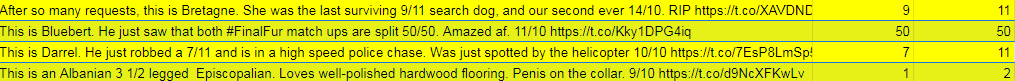

In [56]:
num_p2 = re.compile('(\d+\.?\d?\d?)\/(10)')
for index,rating in (archive_df_clean.loc[archive_df_clean['rating_denominator'] != 10]).iterrows():
    if re.findall(num_p2 , rating['text']) != []:       
        new_numerator=re.findall(num_p2 , rating['text'])[0][0]
        new_denominator_value = re.findall(num_p2, rating['text'])[0][1]
        archive_df_clean.at[index , 'rating_numerator'] = new_numerator_value
        archive_df_clean.at[index , 'rating_denominator'] = new_denominator_value

Test

In [57]:
archive_df_clean.loc[[1662]]

,tweet_id,timestamp,source,text,image_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1662,682962037429899265,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,8.0,10.0,Darrel,NaN,NaN,NaN,NaN


Define

7-c- many values greater than 10, by visualization by excel, I've found that the images related to those ratings has many dogs

make denominator relative to 10

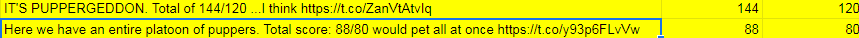

Code

In [58]:
for index,rating in (archive_df_clean.loc[archive_df_clean['rating_denominator'] > 10]).iterrows():
    num_in_image = rating['rating_denominator']/10
    archive_df_clean.at[index , 'rating_numerator'] = rating['rating_numerator']/num_in_image
    archive_df_clean.at[index , 'rating_denominator'] = rating['rating_denominator']/num_in_image

Test

In [59]:
archive_df_clean.loc[[1779]]

,tweet_id,timestamp,source,text,image_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1779,677716515794329600,2015-12-18 05:06:23,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,https://twitter.com/dog_rates/status/677716515...,12.0,10.0,NaN,NaN,NaN,NaN,NaN


In [60]:
archive_df_clean.rating_denominator.value_counts()

10.0    2086
7.0        1
Name: rating_denominator, dtype: int64

Define

7-d- rating 24/7 was recorder but after the tweet, that is not a rating (tweet id =810984652412424192)

set the rating as NaN, as it is not a rating

Code

In [61]:
for index,rating in (archive_df_clean.loc[archive_df_clean['rating_denominator'] != 10]).iterrows():
    archive_df_clean.at[index , 'rating_numerator'] = np.nan
    archive_df_clean.at[index , 'rating_denominator'] = np.nan

Test

In [62]:
archive_df_clean.loc[[516]]

,tweet_id,timestamp,source,text,image_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
516,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",NaN,NaN,Sam,NaN,NaN,NaN,NaN


In [63]:
archive_df_clean.rating_denominator.value_counts()

10.0    2086
Name: rating_denominator, dtype: int64

In [64]:
archive_df_clean.rating_numerator.value_counts()

12.00      487
10.00      434
11.00      418
13.00      283
9.00       153
8.00       103
7.00        51
14.00       38
5.00        33
6.00        32
3.00        19
4.00        15
2.00         9
1.00         4
9.75         1
0.00         1
11.26        1
11.27        1
13.50        1
420.00       1
1776.00      1
Name: rating_numerator, dtype: int64

Define

7-e- rating_numerator has outlier = 1776

we can't fix it, so set the rating as Nan

Code

In [65]:
archive_df_clean.index[archive_df_clean['rating_numerator'] == 1776.00]

Int64Index([979], dtype='int64')

In [66]:
archive_df_clean.at[979, 'rating_numerator'] = np.nan
archive_df_clean.at[979, 'rating_denominator'] = np.nan

Test

In [67]:
archive_df_clean.loc[[979]]

,tweet_id,timestamp,source,text,image_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,NaN,NaN,Atticus,NaN,NaN,NaN,NaN


Define

7-f- rating_numerator has value = 420 , but the image isn't for a dog (tweet id = 855862651834028034)

not realted to our data, set the rating as Nan


Code

In [68]:
archive_df_clean.index[archive_df_clean['rating_numerator'] == 420.00]

Int64Index([2074], dtype='int64')

In [69]:
archive_df_clean.at[2074, 'rating_numerator'] = np.nan
archive_df_clean.at[2074, 'rating_denominator'] = np.nan

Test

In [70]:
archive_df_clean.loc[[2074]]

,tweet_id,timestamp,source,text,image_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2074,670842764863651840,2015-11-29 05:52:33,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
archive_df_clean.rating_numerator.value_counts()

12.00    487
10.00    434
11.00    418
13.00    283
9.00     153
8.00     103
7.00      51
14.00     38
5.00      33
6.00      32
3.00      19
4.00      15
2.00       9
1.00       4
0.00       1
11.27      1
13.50      1
11.26      1
9.75       1
Name: rating_numerator, dtype: int64

In [72]:
archive_df_clean.rating_numerator.describe()

count    2084.000000
mean       10.601142
std         2.148520
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

Define

8- some names wrong extracted - a, an , the , actually, etc

create Regex to extract the word (name of the dog) after 'name is' or 'named'

creat loop to iterate over lowercase and nan values to extract the name or set it as NaN if it isn't possible

convert NaN to none to iterate over the none values in name

then convert none to NaN

Code

In [73]:
archive_df_clean = archive_df_clean.replace(to_replace = np.nan, value = "None")
pattern = re.compile('(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_df_clean.iterrows():
    if row['name'] == 'None' or str(row['name']).islower():
        try:
            c_name = re.findall(pattern,row['text'])[0]
            archive_df_clean.at[index,'name'] = c_name
        except:
            c_name = np.nan
            archive_df_clean.at[index,'name'] = c_name
            
archive_df_clean = archive_df_clean.replace(to_replace = 'None', value = np.nan)

Test

In [74]:
archive_df_clean.name.value_counts(dropna=False)

NaN          672
Oliver        10
Lucy          10
Charlie       10
Cooper        10
Penny          9
Tucker         9
Lola           8
Winston        8
Sadie          8
Daisy          7
Toby           7
Stanley        6
Jax            6
Oscar          6
Bailey         6
Bella          6
Koda           6
Bo             6
Bentley        5
Milo           5
Chester        5
Zoey           5
Leo            5
Scout          5
Dave           5
Buddy          5
Rusty          5
Louis          5
Phil           4
            ... 
Zeek           1
Vinnie         1
Sailer         1
Arya           1
Fiji           1
Tobi           1
Maisey         1
Stella         1
Jeffri         1
Crawford       1
Bookstore      1
Harnold        1
Bobby          1
Striker        1
Shelby         1
Philippe       1
Keet           1
Rose           1
Chadrick       1
Clarq          1
Brandi         1
Jarvis         1
Deacon         1
Kenny          1
Jiminus        1
Ember          1
DayZ           1
Bones         

Define

9- source is a useless column for our analysis

remove it

Code

In [75]:
archive_df_clean = archive_df_clean.drop(['source'], axis=1)

Test

In [76]:
archive_df_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'image_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

Define

Tidness: 2- dog stage (doggo, floofer, pupper and puppo) represented in 4 columns instaed of one

add the 4 columns together in a column called (dog_stage)

by testing: some dogs have more than a stage >>>> seprate between the two words by (-)

Code

In [77]:
archive_df_clean = archive_df_clean.replace(to_replace =np.nan, value = "")
archive_df_clean['dog_stage'] = archive_df_clean['doggo'] + archive_df_clean['floofer'] + archive_df_clean['pupper'] + archive_df_clean['puppo']
archive_df_clean = archive_df_clean.replace(to_replace ="", value = np.nan)

In [78]:
archive_df_clean = archive_df_clean.replace(to_replace ="doggopupper", value = 'doggo-pupper')
archive_df_clean = archive_df_clean.replace(to_replace ="doggofloofer", value = 'doggo-floofer')
archive_df_clean = archive_df_clean.replace(to_replace ="doggopuppo", value = 'doggo-puppo')

In [79]:
archive_df_clean = archive_df_clean.drop(['pupper', 'doggo', 'puppo', 'floofer'], axis=1)

Test

In [80]:
archive_df_clean.sample(5)

,tweet_id,timestamp,text,image_urls,rating_numerator,rating_denominator,name,dog_stage
1811,676819651066732545,2015-12-15 17:42:34,Watch out Airbud. This pupper is also good at ...,https://twitter.com/dog_rates/status/676819651...,12.0,10.0,NaN,pupper
1227,713909862279876608,2016-03-27 02:05:49,This is Doug. His nose is legendary af. 12/10 ...,https://vine.co/v/iDWlapaXWmm,12.0,10.0,Doug,NaN
1656,683357973142474752,2016-01-02 18:43:31,"""Have a seat, son. There are some things we ne...",https://twitter.com/dog_rates/status/683357973...,10.0,10.0,NaN,NaN
2022,672068090318987265,2015-12-02 15:01:33,Say hello to Gizmo. He's upset because he's no...,https://twitter.com/dog_rates/status/672068090...,7.0,10.0,Gizmo,NaN
2041,671542985629241344,2015-12-01 04:14:59,"This is JD (stands for ""just dog""). He's like ...",https://twitter.com/dog_rates/status/671542985...,10.0,10.0,JD,NaN


In [81]:
archive_df_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'image_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

In [82]:
archive_df_clean.dog_stage.value_counts()

pupper           220
doggo             71
puppo             23
floofer            9
doggo-pupper       9
doggo-puppo        1
doggo-floofer      1
Name: dog_stage, dtype: int64

In [83]:
#end of working in archive_df
archive_df.shape

(2356, 17)

Define

api_df_clean: remove retweets, replies and empty image url ids from the df

archive_df_clean has already no retweets , replies or empty image url

Code

In [84]:
api_df_clean = api_df_clean[api_df_clean['id_str'].isin(archive_df_clean['tweet_id'])]

Test

In [85]:
api_df_clean.shape

(2087, 3)

**creating master file**

merge api_df_clean with archive_df_clean

In [86]:
archive_df_clean.shape

(2087, 8)

In [87]:
api_df_clean = api_df_clean.rename(columns={"id_str": "tweet_id"})

In [88]:
api_df_clean.columns

Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')

In [89]:
twitter_archive_master = pd.merge(left=archive_df_clean, right=api_df_clean, how='left', on='tweet_id')

In [90]:
twitter_archive_master.head(5)

,tweet_id,timestamp,text,image_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,7549,35695
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,5595,30872
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,3705,23207
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,7731,38992
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,8332,37253


In [91]:
twitter_archive_master.columns

Index(['tweet_id', 'timestamp', 'text', 'image_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'retweet_count',
       'favorite_count'],
      dtype='object')

In [92]:
twitter_archive_master.shape

(2087, 10)

In [93]:
#creating master file as csv file
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

Define

c- image_prediction_df

convert tweet_ id to string

Code

In [94]:
image_df_clean.tweet_id = image_df_clean.tweet_id.astype('str')

Test

In [95]:
image_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


Define

Tidiness issue - image_df

jpg_url > image_urls (to match the image urls in archive_df clean)

img_num > image_number

p1 > prediction_1

p1_conf > prediction_1_confidence

p1_dog > dog_breed_1

p2 > prediction_2

p2_conf > prediction_2_confidence

p2_dog > dog_breed_1

p3 > prediction_3

p3_conf > prediction_3_confidence

p3_dog> dog_breed_3

Code

In [96]:
image_df_clean = image_df_clean.rename(columns={"jpg_url": "image_urls"})
image_df_clean = image_df_clean.rename(columns={"img_num": "image_number"})

image_df_clean = image_df_clean.rename(columns={"p1": "prediction_1"})
image_df_clean = image_df_clean.rename(columns={"p2": "prediction_2"})
image_df_clean = image_df_clean.rename(columns={"p3": "prediction_3"})

image_df_clean = image_df_clean.rename(columns={"p1_conf": "confidence_1"})
image_df_clean = image_df_clean.rename(columns={"p2_conf": "confidence_2"})
image_df_clean = image_df_clean.rename(columns={"p3_conf": "confidence_3"})

image_df_clean = image_df_clean.rename(columns={"p1_dog": "breed_1"})
image_df_clean = image_df_clean.rename(columns={"p2_dog": "breed_2"})
image_df_clean = image_df_clean.rename(columns={"p3_dog": "breed_3"})

Test

In [97]:
image_df_clean.columns

Index(['tweet_id', 'image_urls', 'image_number', 'prediction_1',
       'confidence_1', 'breed_1', 'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3'],
      dtype='object')

Define 

merge all prediction columns together, confidence columns together and breed columns together  

code

In [98]:
image_df_clean = pd.wide_to_long(image_df_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'image_urls', 'image_number'], j='prediction_level', sep="_").reset_index()

Test

In [99]:
image_df_clean.sample(5)

,tweet_id,image_urls,image_number,prediction_level,prediction,confidence,breed
1867,680497766108381184,https://pbs.twimg.com/media/CXGdG0aWcAEbOO1.jpg,1,2,muzzle,0.084289,False
2219,687127927494963200,https://pbs.twimg.com/media/CYkrNIVWcAMswmP.jpg,1,3,Shih-Tzu,0.120505,True
6189,889880896479866881,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,1,French_bulldog,0.377417,True
3075,710658690886586372,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,1,1,soft-coated_wheaten_terrier,0.948617,True
1592,676819651066732545,https://pbs.twimg.com/media/CWSL4W8WsAAE4KU.jpg,2,3,Labrador_retriever,0.039465,True


Define

replace True with > Yes, it is a dog

replace False with > No, it isn't a dog

Code

In [100]:
image_df_clean = image_df_clean.replace(to_replace =True, value = "Yes, it is a dog")
image_df_clean = image_df_clean.replace(to_replace =False, value = 'No, it isn\'t a dog')

Test

In [101]:
image_df_clean.sample(5)

,tweet_id,image_urls,image_number,prediction_level,prediction,confidence,breed
2536,695095422348574720,https://pbs.twimg.com/media/CaV5mRDXEAAR8iG.jpg,"Yes, it is a dog",2,Chihuahua,0.218128,"Yes, it is a dog"
4200,768609597686943744,https://pbs.twimg.com/media/CqqmWa7WcAAIM-n.jpg,"Yes, it is a dog","Yes, it is a dog",basenji,0.183283,"Yes, it is a dog"
234,667443425659232256,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,"Yes, it is a dog","Yes, it is a dog",goose,0.980815,"No, it isn't a dog"
3379,727524757080539137,https://pbs.twimg.com/media/Chiv6BAW4AAiQvH.jpg,2,2,Chihuahua,0.0240992,"Yes, it is a dog"
6193,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,"Yes, it is a dog",2,Pomeranian,0.0138835,"Yes, it is a dog"


**4-visualization** 

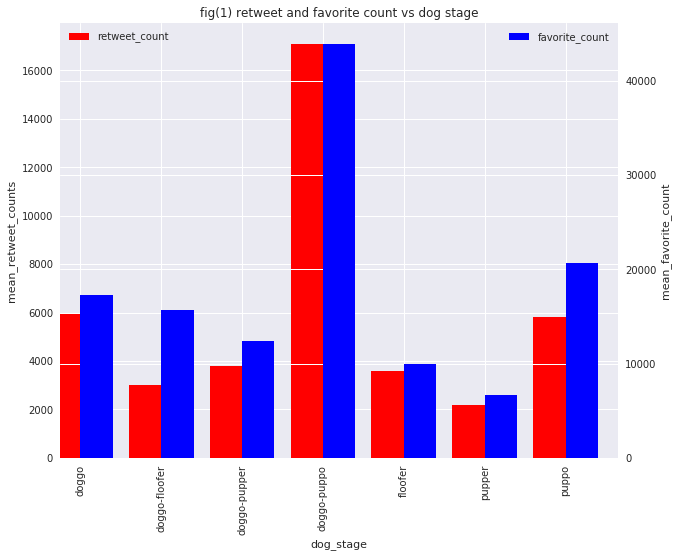

In [102]:
#Plot retweets number and favorite number vs dog stage
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style('darkgrid')

fig = plt.figure() 
ax = fig.add_subplot(111) 
ax2 = ax.twinx()
width = 0.4
titles = "fig(1) retweet and favorite count vs dog stage"
twitter_archive_master.groupby('dog_stage')['retweet_count'].mean().plot(kind='bar', color='red', ax=ax, width=width, position=1, title=titles)
twitter_archive_master.groupby('dog_stage')['favorite_count'].mean().plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('mean_retweet_counts')
ax2.set_ylabel('mean_favorite_count')
ax.legend(loc=2)
ax2.legend()
plt.show()
plt.savefig('fig(1)')

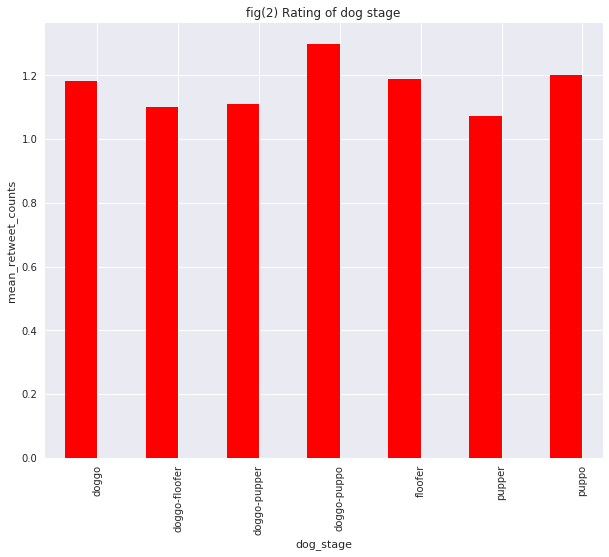

In [103]:
#plot rating vs dog stage
proportions = twitter_archive_master.groupby('dog_stage')['rating_numerator'].mean() / twitter_archive_master.groupby('dog_stage')['rating_denominator'].mean()

fig = plt.figure() 

ax = fig.add_subplot(111) 

width = 0.4

proportions.plot(kind='bar', color='red', ax=ax, width=width, position=1, title='fig(2) Rating of dog stage')

ax.set_ylabel('mean_retweet_counts')

plt.show()

Text(0.5,1,'fig(3)most frequent predictions')

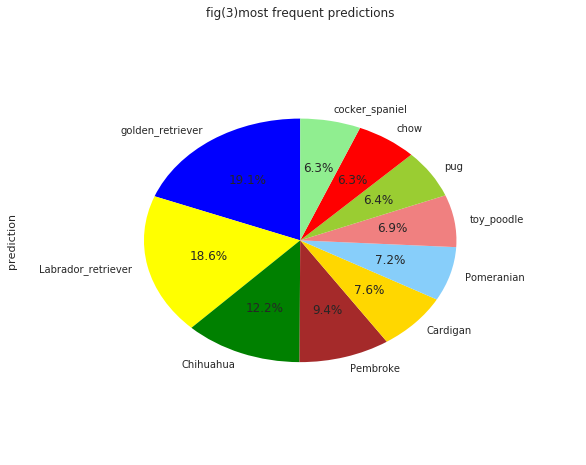

In [104]:
#plot top predictions
colors_set = ["blue", "yellow", "green", "brown", "gold", 'lightskyblue', 'lightcoral', 'yellowgreen', 'red', 'lightgreen']
image_df_clean['prediction'].value_counts().nlargest(10).plot(kind="pie", startangle=90, autopct='%.1f%%', colors=colors_set, radius=0.7)
plt.title('fig(3)most frequent predictions')